### rundown

- clustering does not work
- linear regression works poorly
- the distributions suggest nothing
- i am confused

## crude data analysis

In [639]:
import pandas as pd
import numpy as np
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

content = []
fieldnames = ['reception_time', 'ip', 'controller',
             'order', 'n', 'label', 'lsg', 'sentence', 'answer',
             'correct', 'time']

with open('results.csv', 'r') as f:
    rdr = csv.DictReader(filter(lambda row: row[0]!='#', f), fieldnames=fieldnames)
    for line in rdr:
        content.append(line)
            
df = pd.DataFrame.from_dict(content)
data = df.groupby('sentence').bfill()
data.drop(data[data['label'] == 'id.amb.c'].index, inplace=True)
data.drop(data[data['correct'] != 'NULL'].index, inplace=True)
data.drop(data[data['controller'] != 'AcceptabilityJudgment'].index, inplace=True)
data.drop(columns=['correct', 'order', 'n', 'lsg', 'reception_time', 'controller'], inplace=True)
data['answer'] = data['answer'].astype(int)
wrong_ips = ['182132ac5a39cb9901f7d219aee9725d',
 '360d4f219052372d21805b75b756c4fa',
 '94745e41b11a01b5629c2e12eafb12e7',
 'b38d667475915e4099823b83896cf4ae']
for wrong in wrong_ips:
    data.drop(data.loc[data['ip'] == wrong].index, inplace=True)
data['answer'] = data.groupby('ip')['answer'].transform(lambda x: (x - x.mean()) / x.std())

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

def standardise(x):
    scaler.fit(x)
    return scaler.transform(x)

#data[['answer', 'time']] = standardise(np.array(data[['answer', 'time']]))
data['time'] = standardise(np.array(data['time']).reshape(-1, 1))
data

,ip,label,answer,time
1,768f35facd7274bec5720cfc2b65d8b7,practice1,1.089583,-0.599776
3,768f35facd7274bec5720cfc2b65d8b7,practice2,-1.019287,-0.578546
5,768f35facd7274bec5720cfc2b65d8b7,Fu-1F.01,-1.019287,-0.578412
7,768f35facd7274bec5720cfc2b65d8b7,id.sub.a,-1.019287,-0.361890
9,768f35facd7274bec5720cfc2b65d8b7,Fg-8F.02,1.089583,-0.479025
...,...,...,...,...
3567,aa43a9471d001423711806402efdaaad,noid.sub.d,0.913514,-0.532536
3569,aa43a9471d001423711806402efdaaad,Fu-3F.01,-1.461622,-0.382049
3571,aa43a9471d001423711806402efdaaad,Fg-8F.02,0.913514,-0.474538
3573,aa43a9471d001423711806402efdaaad,id.amb.a,0.913514,-0.377294


In [640]:
fillers = data[data['label'].str.startswith('F')]
fillers['grammatical'] = fillers['label'].str[1]
fillers['grammatical'] = fillers['grammatical'].map({'u':0, 'g':1})
fillers.drop(columns=['ip', 'label'], inplace=True)
#fillers.to_csv('fillers.csv', index=False)
fillers

<ipython-input-640-2e6f1a5fa54f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fillers['grammatical'] = fillers['label'].str[1]
<ipython-input-640-2e6f1a5fa54f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fillers['grammatical'] = fillers['grammatical'].map({'u':0, 'g':1})
/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

,answer,time,grammatical
5,-1.019287,-0.578412,0
9,1.089583,-0.479025,1
11,-1.019287,-0.525169,0
15,1.089583,-0.340727,1
17,-1.019287,-0.530326,0
...,...,...,...
3555,0.517658,-0.352313,1
3561,-1.461622,-0.354590,0
3563,0.913514,-0.146173,1
3569,-1.461622,-0.382049,0


In [641]:
test = data[(data['label'].str.startswith('id')) | (data['label'].str.startswith('no'))]
test['idiom'] = test['label'].apply(lambda x: x.split('.')[0])
test['type'] = test['label'].apply(lambda x: x.split('.')[1])
test['idiom'] = test['idiom'].map({'id':1, 'noid':0})
test[['amb', 'obj', 'sub']] = pd.get_dummies(test['type'])
test.reset_index(drop=True, inplace=True)
#test['answer'] = test.groupby('ip')['answer'].transform('std')
test.drop(columns=['type', 'label', 'ip'], inplace=True)
test.to_csv('test_items.csv', index=False)
test

<ipython-input-641-6b5c8214a1ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['idiom'] = test['label'].apply(lambda x: x.split('.')[0])
<ipython-input-641-6b5c8214a1ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['type'] = test['label'].apply(lambda x: x.split('.')[1])
<ipython-input-641-6b5c8214a1ca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,answer,time,idiom,amb,obj,sub
0,-1.019287,-0.361890,1,0,0,1
1,0.738105,-0.330279,1,0,1,0
2,-1.019287,-0.548810,1,1,0,0
3,0.386626,-0.557115,1,0,1,0
4,-0.316331,-0.219239,1,1,0,0
...,...,...,...,...,...,...
588,0.913514,-0.567495,0,0,1,0
589,0.913514,0.129017,1,0,1,0
590,0.913514,-0.532536,0,0,0,1
591,0.913514,-0.377294,1,1,0,0


## factor analysis

In [605]:
from sklearn.decomposition import FactorAnalysis

X = np.array(test[test.columns[1:]])
transformer = FactorAnalysis(n_components=7, random_state=0)
X = transformer.fit_transform(X)
X.shape

(624, 5)

### linear regression

In [642]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X = np.array(test[test.columns[1:]])
y = np.array(test['answer'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print(model.coef_)
print(test.columns[1:])

[ 0.01873093 -0.32205902 -0.16984195 -0.07017779  0.24001974]
Index(['time', 'idiom', 'amb', 'obj', 'sub'], dtype='object')


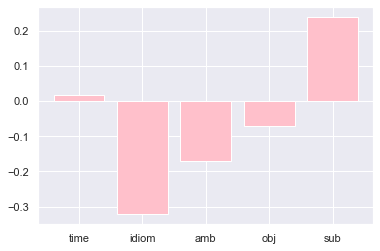

<Figure size 432x288 with 0 Axes>

In [643]:
import matplotlib.pyplot as plt
%matplotlib inline

Y = model.coef_
x = list(test.columns[1:])

plt.bar(x, Y, color='pink')
plt.show()
plt.savefig('weights.png')

In [601]:
ws = pd.DataFrame({'param':x, 'weight':Y})
ws = ws.sort_values(by=['weight'])
ws.to_csv('weights.csv')
ws

,param,weight
1,idiom,-0.293678
2,amb,-0.231647
3,obj,-0.026764
0,time,0.015194
4,sub,0.258411


In [645]:
print('test predictions MAE: ', mean_absolute_error(y_test, preds_test))
y_test[:30]

test predictions MAE:  0.5921085155981208


array([-1.4425848 , -0.72813614,  0.82289446, -1.03648399, -1.19893059,
       -1.08151099,  0.82289446,  0.09161683, -0.07791205,  0.62562816,
        0.96844   ,  0.58351745,  0.12180187,  0.71004432, -0.54958939,
        0.87393187,  0.913514  ,  0.63933675,  1.1735909 ,  0.33804507,
       -0.86111758, -0.23411043,  0.297746  ,  0.812835  ,  0.49173308,
        0.97678941, -1.07038105,  0.73810463,  0.93392439, -1.54398692])

### respondent simulator

In [532]:
import random 

# 'time', 'idiom', 'amb', 'obj', 'sub'
d = random.uniform(test['time'].min(), test['time'].max()) 
pred = model.predict(np.array([d, 1, 0, 1, 0]).reshape(1, -1))

arr = np.array([1,1,1,1,1,1, # Fu
         7,7,7,7,7,7, # Fg
         7,6,7,6,6,7, # no idiom
        random.randrange(1, 8),random.randrange(1, 8),random.randrange(1, 8),
        random.randrange(1, 8),random.randrange(1, 8),random.randrange(1, 8)])

ans = pred * arr.std() + arr.mean()
ans[0]

5.380207544876529

<AxesSubplot:xlabel='type', ylabel='idiom'>

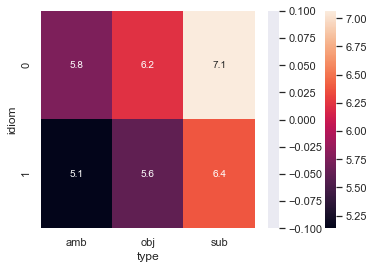

In [533]:
t_c = {
    'amb': [1,0,0],
    'obj': [0,1,0],
    'sub': [0,0,1]
}
l0 = []
l1 = []

for key in t_c:
    d = random.uniform(test['time'].min(), test['time'].max()) 
    pred = model.predict(np.array([d, 0] + t_c[key]).reshape(1, -1))[0]
    l0.append(pred * arr.std() + arr.mean())
    
for key in t_c:
    d = random.uniform(test['time'].min(), test['time'].max()) 
    pred = model.predict(np.array([d, 1] + t_c[key]).reshape(1, -1))[0]
    l1.append(pred * arr.std() + arr.mean())

labels = pd.DataFrame({'idiom': [0, 1, 0, 1, 0, 1],
                      'type': ['amb','obj','sub','amb','obj','sub'],
                      'answer': [0,0,0,0,0,0]})
    
hm = np.array([l0, l1])
sns.heatmap(hm, annot=True)
sns.heatmap(data=labels.pivot('idiom', 'type', 'answer'), alpha=0.0)

### linearSVC

In [574]:
from sklearn.svm import LinearSVC
import numpy as np

content = []
fieldnames = ['reception_time', 'ip', 'controller',
             'order', 'n', 'label', 'lsg', 'sentence', 'answer',
             'correct', 'time']

with open('results.csv', 'r') as f:
    rdr = csv.DictReader(filter(lambda row: row[0]!='#', f), fieldnames=fieldnames)
    for line in rdr:
        content.append(line)
            
df = pd.DataFrame.from_dict(content)
for wrong in wrong_ips:
    df.drop(df.loc[df['ip'] == wrong].index, inplace=True)
data = df.groupby('ip').bfill()
data = data[(data['label'].str.startswith('id')) | (data['label'].str.startswith('no'))]
data.drop(data[data['sentence'] == 'NULL'].index, inplace=True)
data.drop(data[data['controller'] != 'AcceptabilityJudgment'].index, inplace=True)
data.drop(columns=['correct', 'order', 'n', 'lsg', 'reception_time', 'controller'], inplace=True)
data['answer'] = data['answer'].astype(int)
data['idiom'] = data['label'].apply(lambda x: x.split('.')[0])
data['type'] = data['label'].apply(lambda x: x.split('.')[1])
data['idiom'] = data['idiom'].map({'id':1, 'noid':0})
data[['amb', 'obj', 'sub']] = pd.get_dummies(data['type'])
data

,label,sentence,answer,time,idiom,type,amb,obj,sub
6,id.sub.a,Егор продолжал биться над поделкой%2C но работ...,1,7122,1,sub,0,0,1
12,id.obj.a,Контора неумолимо приближалась к банкротству%2...,6,7594,1,obj,0,1,0
18,id.amb.d,Разрушительная война наконец закончилась%2C и ...,1,4331,1,amb,1,0,0
24,id.obj.d,Напряженное молчание заставляло атмосферу сгущ...,5,4207,1,obj,0,1,0
30,id.amb.a,Дружелюбный настрой Костиных новых знакомых и ...,3,9252,1,amb,1,0,0
...,...,...,...,...,...,...,...,...,...
3558,noid.obj.a,Каждую субботу мама заставляет нас с сестрой у...,7,4052,0,obj,0,1,0
3564,id.obj.a,Контора неумолимо приближалась к банкротству%2...,7,14452,1,obj,0,1,0
3566,noid.sub.d,Все уже были готовы выезжать%2C когда позвонил...,7,4574,0,sub,0,0,1
3572,id.amb.a,Дружелюбный настрой Костиных новых знакомых и ...,7,6892,1,amb,1,0,0


In [536]:
t = data.loc[data['idiom'] == 1]

y = np.array(t['answer'])
X = np.array(t[['idiom', 'amb', 'sub', 'obj', 'time']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

model = LinearSVC(random_state=0, tol=1e-7)
model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print('test accuracy: ', accuracy_score(y_test, preds_test))

model.classes_

test accuracy:  0.1232876712328767


/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


array([1, 2, 3, 4, 5, 6, 7])

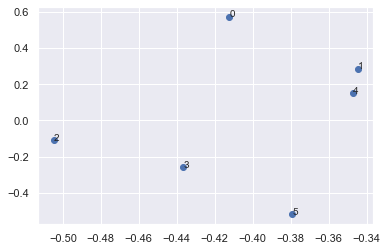

In [537]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

m = model.coef_.transpose()
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(m)
XY = svd.components_.transpose()

x = XY[:-1, 0]
y = XY[:-1, 1]

plt.scatter(x, y)
for i, txt in enumerate(range(6)):
    plt.annotate(txt, (x[i], y[i]))

### fewer classes

In [615]:
data['answer_short'] = data['answer'].map({1:0, 2:0, 3:0, 4:1, 5:2, 6:2, 7:2})

#t = data.loc[data['idiom'] == 1]
t = data
y = np.array(t['answer_short'])
X = np.array(t[['idiom', 'amb', 'sub', 'obj', 'time']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

model = LinearSVC(random_state=0, tol=1e-7)
model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print('test accuracy: ', accuracy_score(y_test, preds_test))

print(model.coef_)

KeyError: "['sub', 'obj', 'idiom', 'amb'] not in index"

In [647]:
r = 0.05

def mapper(s):
    if s < -r:
        return 0
    if s > r:
        return 2
    else:
        return 1

#t = data.loc[data['idiom'] == 1]
t = test
t['answer_short'] = t['answer'].apply(mapper)
y = np.array(t['answer_short'])
X = np.array(t[['idiom', 'amb', 'sub', 'obj', 'time']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

model = LinearSVC(random_state=0, tol=1e-7)
model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print('test accuracy: ', accuracy_score(y_test, preds_test))

print(model.coef_)

test accuracy:  0.6734006734006734
[[ 0.28607237  0.04833115 -0.35039961 -0.13120785 -0.01348752]
 [-0.01121221 -0.23299915 -0.24339505 -0.23572497 -0.03366314]
 [-0.28032501 -0.06502133  0.34440669  0.11900687  0.02944985]]


<ipython-input-647-790148113598>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['answer_short'] = t['answer'].apply(mapper)
/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


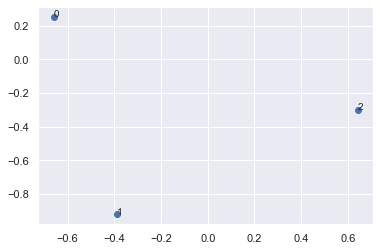

In [648]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

m = model.coef_.transpose()
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(m)
XY = svd.components_.transpose()

x = XY[:, 0]
y = XY[:, 1]

plt.scatter(x, y)
for i, txt in enumerate(range(3)):
    plt.annotate(txt, (x[i], y[i]))
    


### kNN

In [649]:
from sklearn.neighbors import KNeighborsClassifier

#t = data.loc[data['idiom'] == 1]

y = np.array(t['answer_short'])
X = np.array(t[['idiom', 'amb', 'sub', 'obj', 'time']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

print('test accuracy: ', accuracy_score(y_test, preds_test))

test accuracy:  0.5993265993265994


## test items overview

In [541]:
import pandas as pd
import numpy as np
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

content = []
fieldnames = ['reception_time', 'ip', 'controller',
             'order', 'n', 'label', 'lsg', 'sentence', 'answer',
             'correct', 'time']

with open('results.csv', 'r') as f:
    rdr = csv.DictReader(filter(lambda row: row[0]!='#', f), fieldnames=fieldnames)
    for line in rdr:
        content.append(line)
            
df = pd.DataFrame.from_dict(content)
for wrong in wrong_ips:
    df.drop(df.loc[df['ip'] == wrong].index, inplace=True)
data = df.groupby('ip').bfill()
data.drop(data[data['sentence'] == 'NULL'].index, inplace=True)
data.drop(data[data['controller'] != 'AcceptabilityJudgment'].index, inplace=True)
data.drop(columns=['correct', 'order', 'n', 'lsg', 'reception_time', 'controller'], inplace=True)
data['answer'] = data['answer'].astype(int)
data

,label,sentence,answer,time
0,practice1,Ульяна сегодня надела своё любимое нежно-сирен...,7,3570
2,practice2,К нам надвигалось стая громкого угрожающе и кр...,1,3887
4,Fu-1F.01,Как только я вышел из дома%2C пошли сильный снег.,1,3889
6,id.sub.a,Егор продолжал биться над поделкой%2C но работ...,1,7122
8,Fg-8F.02,Пока что папа занят%2C но ты можешь зайти чере...,7,5373
...,...,...,...,...
3566,noid.sub.d,Все уже были готовы выезжать%2C когда позвонил...,7,4574
3568,Fu-3F.01,Поля любила ароматические свечей%2C но больше ...,1,6821
3570,Fg-8F.02,Пока что папа занят%2C но ты можешь зайти чере...,7,5440
3572,id.amb.a,Дружелюбный настрой Костиных новых знакомых и ...,7,6892


In [589]:
exes = data[(data['label'].str.startswith('id')) | (data['label'].str.startswith('no'))]
exes['idiom'] = exes['label'].apply(lambda x: x.split('.')[0])
exes['type'] = exes['label'].apply(lambda x: x.split('.')[1])
exes['idiom'] = exes['idiom'].map({'id':1, 'noid':0})
exes[['amb', 'obj', 'sub']] = pd.get_dummies(exes['type'])
exes.reset_index(drop=True, inplace=True)
#exes.drop(columns=['label'], inplace=True)
exes

<ipython-input-589-6fa137a9da8a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exes['idiom'] = exes['label'].apply(lambda x: x.split('.')[0])
<ipython-input-589-6fa137a9da8a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exes['type'] = exes['label'].apply(lambda x: x.split('.')[1])
<ipython-input-589-6fa137a9da8a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,ip,label,answer,time,idiom,type,amb,obj,sub
0,768f35facd7274bec5720cfc2b65d8b7,id.sub.a,-1.019287,-0.362637,1,sub,0,0,1
1,768f35facd7274bec5720cfc2b65d8b7,id.obj.a,0.738105,-0.330773,1,obj,0,1,0
2,768f35facd7274bec5720cfc2b65d8b7,id.amb.d,-1.019287,-0.551055,1,amb,1,0,0
3,768f35facd7274bec5720cfc2b65d8b7,id.obj.d,0.386626,-0.559427,1,obj,0,1,0
4,768f35facd7274bec5720cfc2b65d8b7,id.amb.a,-0.316331,-0.218843,1,amb,1,0,0
...,...,...,...,...,...,...,...,...,...
619,aa43a9471d001423711806402efdaaad,noid.obj.a,0.913514,-0.569891,0,obj,0,1,0
620,aa43a9471d001423711806402efdaaad,id.obj.a,0.913514,0.132205,1,obj,0,1,0
621,aa43a9471d001423711806402efdaaad,noid.sub.d,0.913514,-0.534651,0,sub,0,0,1
622,aa43a9471d001423711806402efdaaad,id.amb.a,0.913514,-0.378165,1,amb,1,0,0


### non z scored stats

#### test items

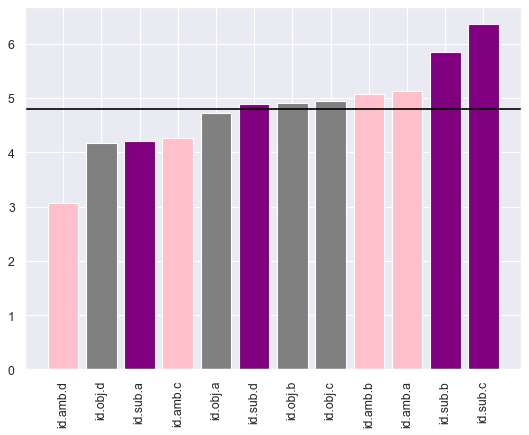

In [576]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

d = dict(exes[exes['idiom'] == 1].groupby('label')['answer'].mean())
d = dict(sorted(d.items(), key=lambda x: x[1]))
x = d.keys()
y = d.values()

words = ['amb', 'sub', 'obj']
colors = ['pink', 'purple', 'grey']
for key, val in d.items():
    plt.bar(key, val, color=colors[words.index(key.split('.')[1])])
plt.axhline(y=np.mean(list(y)), color='black')
plt.xticks(rotation=90)
plt.savefig('general.png')

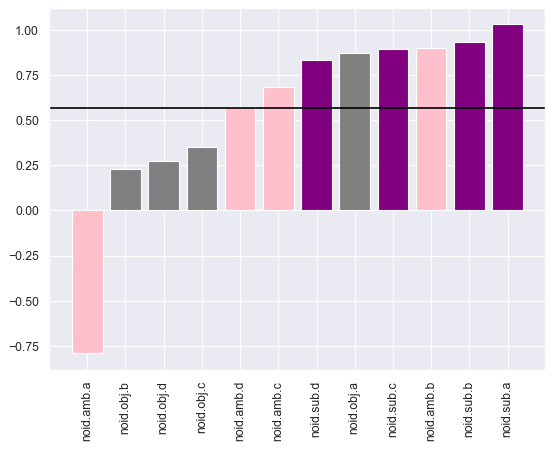

In [590]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

d = dict(exes[exes['idiom'] == 0].groupby('label')['answer'].mean())
d = dict(sorted(d.items(), key=lambda x: x[1]))
x = d.keys()
y = d.values()

words = ['amb', 'sub', 'obj']
colors = ['pink', 'purple', 'grey']
for key, val in d.items():
    plt.bar(key, val, color=colors[words.index(key.split('.')[1])])
plt.axhline(y=np.mean(list(y)), color='black')
plt.xticks(rotation=90)
plt.savefig('general_noid.png')

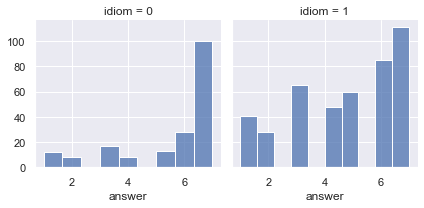

In [544]:
import seaborn as sns

#sns.displot(data=exes[exes['idiom'] == 0], x='answer', kde=True)
#sns.displot(data=exes[exes['idiom'] == 1], x='answer', kde=True)

g = sns.FacetGrid(exes, col="idiom")
g.map(sns.histplot, "answer")

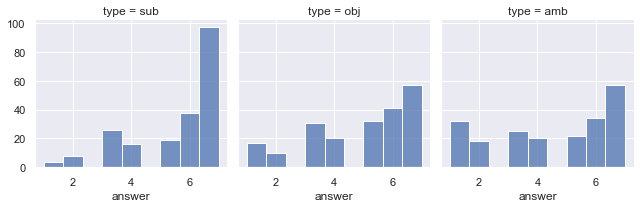

In [545]:
g = sns.FacetGrid(exes, col="type")
g.map(sns.histplot, "answer")

/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


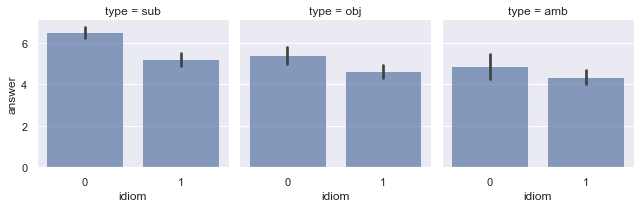

In [547]:
g = sns.FacetGrid(exes, col="type")
g.map(sns.barplot, "idiom", "answer", alpha=.7)

In [548]:
exes['answer'] = exes['answer'].transform(lambda x: (x - x.mean()) / x.std())

<ipython-input-548-360f5ae17c2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exes['answer'] = exes['answer'].transform(lambda x: (x - x.mean()) / x.std())


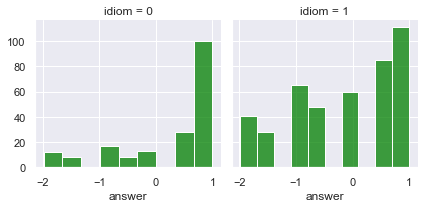

In [549]:
g = sns.FacetGrid(exes, col="idiom")
g.map(sns.histplot, "answer", color='green')

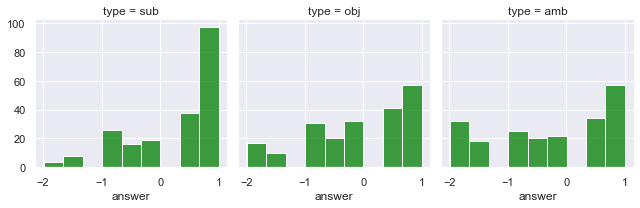

In [550]:
g = sns.FacetGrid(exes, col="type")
g.map(sns.histplot, "answer", color='green')

/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


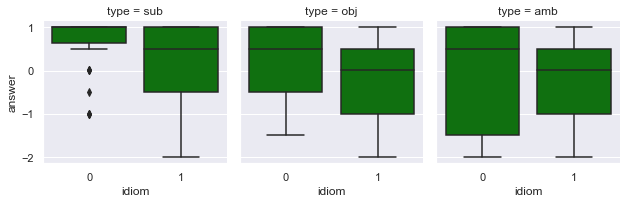

In [570]:
sns.set(rc={'figure.figsize':(15,5)})
g = sns.FacetGrid(exes, col="type")
g.map(sns.boxplot, "idiom", "answer", color='green')
g.savefig('type_dist.png')

#### fillers

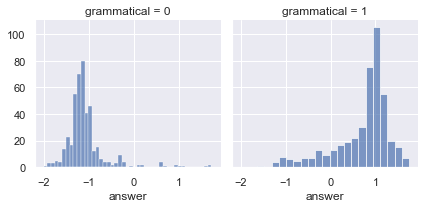

In [552]:
g = sns.FacetGrid(fillers, col="grammatical")
g.map(sns.histplot, "answer", alpha=.7)

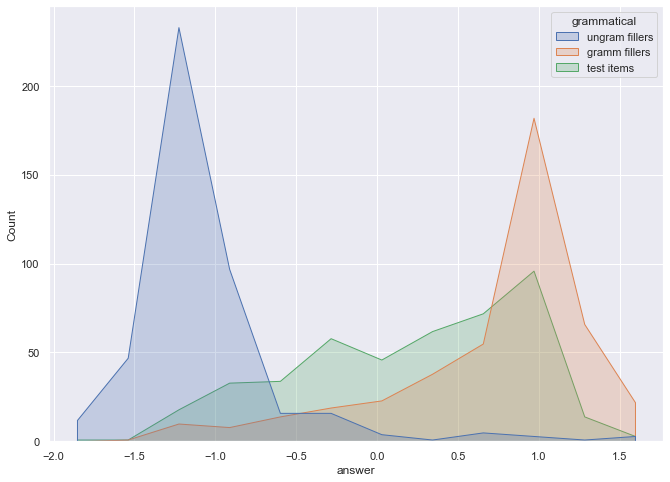

In [566]:
content = []
fieldnames = ['reception_time', 'ip', 'controller',
             'order', 'n', 'label', 'lsg', 'sentence', 'answer',
             'correct', 'time']

with open('results.csv', 'r') as f:
    rdr = csv.DictReader(filter(lambda row: row[0]!='#', f), fieldnames=fieldnames)
    for line in rdr:
        content.append(line)
            
df = pd.DataFrame.from_dict(content)
for wrong in wrong_ips:
    df.drop(df.loc[df['ip'] == wrong].index, inplace=True)
data = df.groupby('sentence').bfill()
data.drop(data[data['correct'] != 'NULL'].index, inplace=True)
data.drop(data[data['controller'] != 'AcceptabilityJudgment'].index, inplace=True)
data.drop(columns=['correct', 'order', 'n', 'lsg', 'reception_time', 'controller'], inplace=True)
data['answer'] = data['answer'].astype(int)
data['answer'] = data.groupby('ip')['answer'].transform(lambda x: (x - x.mean()) / x.std())
ti = data.loc[data['label'].str.startswith('id')]
ti = ti[['answer', 'time']]
ti['grammatical'] = 2
tnf = pd.concat([fillers, ti], ignore_index=True)
tnf['grammatical'] = tnf['grammatical'].map({0:'ungram fillers', 1:'gramm fillers', 2:'test items'})

sns.set(rc={'figure.figsize':(11,8)})
fig = sns.histplot(data=tnf, x="answer", hue="grammatical", element="poly").get_figure()
#fig.set_axis_labels('answer', 'respondent count')
fig.savefig('gramm_ungramm.png')

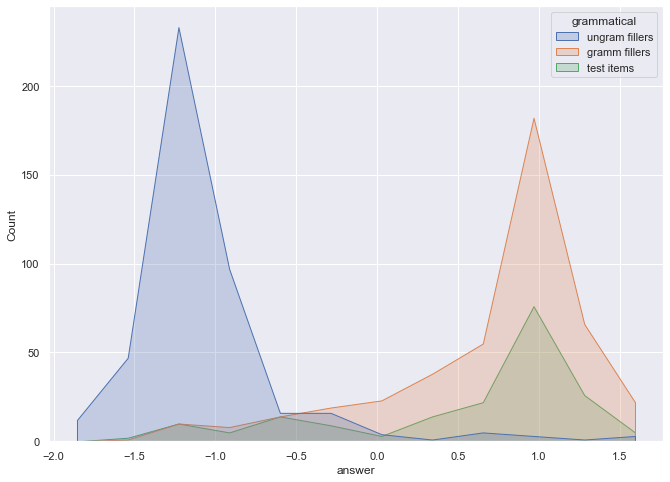

In [585]:
ti = data.loc[data['label'].str.startswith('noid')]
ti = ti[['answer', 'time']]
ti['grammatical'] = 2
tnf = pd.concat([fillers, ti], ignore_index=True)
tnf['grammatical'] = tnf['grammatical'].map({0:'ungram fillers', 1:'gramm fillers', 2:'test items'})

sns.set(rc={'figure.figsize':(11,8)})
fig = sns.histplot(data=tnf, x="answer", hue="grammatical", element="poly").get_figure()
#fig.set_axis_labels('answer', 'respondent count')
fig.savefig('gramm_ungramm_noid.png')

## remove the outliers

In [556]:
df = pd.DataFrame.from_dict(content)
data = df.groupby('sentence').bfill()
data.drop(data[data['correct'] != 'NULL'].index, inplace=True)
data.drop(data[data['controller'] != 'AcceptabilityJudgment'].index, inplace=True)
data.drop(columns=['correct', 'order', 'n', 'lsg', 'reception_time', 'controller'], inplace=True)
data['answer'] = data['answer'].astype(int)

fillers = data[data['label'].str.startswith('F')]
fillers['grammatical'] = fillers['label'].str[1]
fillers['grammatical'] = fillers['grammatical'].map({'u':0, 'g':1})
fillers.drop(columns=['label'], inplace=True)
fillers

<ipython-input-556-7075082c838f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fillers['grammatical'] = fillers['label'].str[1]
<ipython-input-556-7075082c838f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fillers['grammatical'] = fillers['grammatical'].map({'u':0, 'g':1})
/Users/shikunova/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

,ip,answer,time,grammatical
5,768f35facd7274bec5720cfc2b65d8b7,1,3889,0
9,768f35facd7274bec5720cfc2b65d8b7,7,5373,1
11,768f35facd7274bec5720cfc2b65d8b7,1,4684,0
15,768f35facd7274bec5720cfc2b65d8b7,7,7438,1
17,768f35facd7274bec5720cfc2b65d8b7,1,4607,0
...,...,...,...,...
3555,aa43a9471d001423711806402efdaaad,6,7265,1
3561,aa43a9471d001423711806402efdaaad,1,7231,0
3563,aa43a9471d001423711806402efdaaad,7,10343,1
3569,aa43a9471d001423711806402efdaaad,1,6821,0


In [555]:
ips = pd.pivot_table(fillers, values='answer', index='ip', columns='grammatical', aggfunc=np.average)
ips = ips.reset_index().rename_axis(None, axis=1)
ips

,ip,0,1
0,008edcdb4103bbff8f81f1c817db89a5,2.000000,5.166667
1,0273cc424205f73f470fe3d26348b9c2,1.500000,5.833333
2,05f475a6456c929e7b81d1621aaed515,1.166667,7.000000
3,07cdd46f6d733b4120a28f03c7f2e1bc,1.666667,5.833333
4,0b40d0a708b92589cabbfdc615411f4d,3.000000,5.666667
...,...,...,...
68,f34415c6b97c2d997e354fb79ffa14bc,1.833333,6.833333
69,f88d81331731fa70e26f7f9c475f45cc,1.000000,5.500000
70,f8cd7db158063af9356b4de6ae4350ae,3.000000,4.166667
71,fd90bc35ebc64c5bf9f10f9d1261f0ba,1.166667,6.000000


In [521]:
bad = []

for row in ips.loc[(ips[1] <= 4) | (ips[0] >= 4)].iterrows():
    bad.append(row[0])
    
bad = list(bad)
list(ips.loc[bad]['ip'])

['182132ac5a39cb9901f7d219aee9725d',
 '360d4f219052372d21805b75b756c4fa',
 '94745e41b11a01b5629c2e12eafb12e7',
 'b38d667475915e4099823b83896cf4ae']

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
fig.set_axis_labels('', '')
fig.savefig('')